In [37]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기

In [38]:
df = pd.read_csv('/Users/zoohunn/Desktop/비어플/비어플[금융]/datasets/final_data_1102.csv')
df.head()

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Unnamed: 0,individual_id,curr_ann_amt,days_tenure,date_of_birth,income,has_children,length_of_residence,home_market_value,age_in_years,...,dgs10_at_orig,cpi_at_orig,unrate_at_orig,sp500_at_orig,tax_benefit_status,surrender_penalty_rate,breakeven_reached,contact_frequency,payment_delay_history,contact_group
0,0,2.213000e+11,818.877997,1454.0,1978-06-23,22500.0,1,15.0,50000 - 74999,44,...,2.832632,252.767,3.9,2567.307386,not_qualified,0.40,0,3,0,3-4회
1,1,2.213001e+11,974.199182,1795.0,1950-05-30,27500.0,0,2.0,50000 - 74999,72,...,2.583810,248.859,4.0,2789.803816,not_qualified,0.20,0,1,0,0-2회
2,2,2.213007e+11,967.375112,4818.0,1967-07-07,42500.0,0,10.0,75000 - 99999,55,...,3.401905,215.861,9.8,1044.552383,qualified,0.00,1,2,0,0-2회
3,3,2.213016e+11,992.409561,130.0,1969-05-25,125000.0,1,6.0,175000 - 199999,53,...,2.896000,294.940,3.5,3911.729492,not_qualified,0.95,0,6,0,5-6회
4,4,2.213016e+11,784.633494,5896.0,1972-09-25,87500.0,1,4.0,225000 - 249999,50,...,4.729048,201.900,4.4,1363.377264,qualified,0.00,1,1,0,0-2회


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641992 entries, 0 to 1641991
Data columns (total 37 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Unnamed: 0              1641992 non-null  int64  
 1   individual_id           1641992 non-null  float64
 2   curr_ann_amt            1641992 non-null  float64
 3   days_tenure             1641992 non-null  float64
 4   date_of_birth           1641992 non-null  object 
 5   income                  1641992 non-null  float64
 6   has_children            1641992 non-null  int64  
 7   length_of_residence     1641992 non-null  float64
 8   home_market_value       1641992 non-null  object 
 9   age_in_years            1641992 non-null  int64  
 10  home_owner              1641992 non-null  float64
 11  college_degree          1641992 non-null  float64
 12  good_credit             1641992 non-null  float64
 13  cust_orig_year          1641992 non-null  int64  
 14  cu

In [40]:
# duration / event 정의
df["duration_years"] = df["days_tenure"] / 365.25
df["event"] = df["churn"].astype(int)
df["cust_orig_year"] = pd.to_datetime(df["cust_orig_month"]).dt.year

In [41]:
# 가입연도 추출 -> Train/Test 분할
df["cust_orig_year"] = pd.to_datetime(df["cust_orig_month"]).dt.year

# 학습/평가 분할
year_train = [2012, 2013, 2014, 2015, 2016]
year_test  = [2017, 2018]
train_df = df[df["cust_orig_year"].isin(year_train)].copy()
test_df  = df[df["cust_orig_year"].isin(year_test)].copy()

In [42]:
selected_vars = [
    "cpi_at_orig", "gdp_at_orig", "length_of_residence",
    "college_degree", "has_children", "premium_to_income",
    "sp500_at_orig", "curr_ann_amt", "dgs10_at_orig", "age_at_orig",
    "home_owner", "unrate_at_orig", "good_credit"
]
X_cols = [c for c in selected_vars if c in df.columns]

imp = SimpleImputer(strategy="median")
scl = StandardScaler()

X_train = pd.DataFrame(imp.fit_transform(train_df[X_cols]), columns=X_cols, index=train_df.index)
X_test  = pd.DataFrame(imp.transform(test_df[X_cols]),    columns=X_cols, index=test_df.index)

X_train_std = pd.DataFrame(scl.fit_transform(X_train), columns=X_cols, index=train_df.index)
X_test_std  = pd.DataFrame(scl.transform(X_test), columns=X_cols, index=test_df.index)

In [43]:
## X_test 데이터 기초통계량들 확인
print(X_test_std.describe().T.head())


                        count      mean       std       min       25%  \
cpi_at_orig          156334.0  3.414789  0.894558  2.179869  2.335041   
gdp_at_orig          156334.0  2.690900  0.632188  1.751818  1.921579   
length_of_residence  156334.0  0.014619  0.997007 -1.405663 -0.813552   
college_degree       156334.0  0.009293  1.003112 -0.716408 -0.716408   
has_children         156334.0  0.023215  0.998132 -1.071308 -1.071308   

                          50%       75%       max  
cpi_at_orig          3.594226  4.229756  4.650204  
gdp_at_orig          2.874359  3.377753  3.505307  
length_of_residence -0.221441  0.962781  1.554892  
college_degree      -0.716408  1.395853  1.395853  
has_children         0.933438  0.933438  0.933438  


### COX 생존분석모델학습

In [44]:
train_for_cox = pd.concat([train_df[["duration_years", "event"]], X_train_std], axis=1)
test_for_cox  = pd.concat([test_df[["duration_years", "event"]],  X_test_std],  axis=1)

cph = CoxPHFitter(penalizer=0.5, l1_ratio=0.0)
cph.fit(train_for_cox, duration_col="duration_years", event_col="event")
print("✅ 모델 학습 완료")

✅ 모델 학습 완료


In [45]:
ph = cph.predict_partial_hazard(test_for_cox).squeeze()
print("partial hazard 고유값 개수:", ph.nunique())
print(ph.describe())

partial hazard 고유값 개수: 156334
count    156334.000000
mean          2.992606
std           0.682556
min           1.936431
25%           2.246897
50%           3.186960
75%           3.635559
max           4.084830
dtype: float64


In [46]:
# 모델 평가
from lifelines.utils import concordance_index

# Train
train_pred = cph.predict_partial_hazard(train_for_cox)
c_train = concordance_index(train_df["duration_years"], -train_pred.values.ravel(), train_df["event"])
# Test
test_pred = cph.predict_partial_hazard(test_for_cox)
c_test = concordance_index(test_df["duration_years"], -test_pred.values.ravel(), test_df["event"])
print(f"C-index (Train): {c_train:.3f} | (Test): {c_test:.3f}")


C-index (Train): 0.969 | (Test): 0.935


결론 : 학습의 우위가 약간 있으나, 과적합은 아님
추가 확인 포인트

더 확실히 판단하려면 다음을 보면 좋아요:

1. Validation 세트 C-index (Train/Valid/Test 3개로 분리해 평가)

2. Penalizer 조정 (규제 강도)

penalizer 값을 5.0 → 10.0 정도로 늘려보면
overfitting이 있다면 Train은 약간 낮아지고 Test는 개선될 가능성 있음.

3. 변수 중요도 확인

cph.summary에서 exp(coef)가 매우 큰(>5) 변수가 많다면 일부 변수가 과도하게 영향을 줬을 수도 있음.

In [47]:
summary = cph.summary.sort_values("p")
print(summary[["coef", "exp(coef)", "p"]])

                         coef  exp(coef)         p
covariate                                         
cpi_at_orig          0.101715   1.107068  0.000000
gdp_at_orig          0.100574   1.105805  0.000000
sp500_at_orig        0.098914   1.103971  0.000000
unrate_at_orig      -0.099080   0.905670  0.000000
age_at_orig          0.007445   1.007473  0.002257
curr_ann_amt         0.002624   1.002627  0.283972
dgs10_at_orig        0.002368   1.002371  0.339890
college_degree      -0.001226   0.998775  0.616111
good_credit         -0.000917   0.999083  0.707957
has_children        -0.000567   0.999433  0.816688
home_owner           0.000237   1.000237  0.923116
premium_to_income   -0.000232   0.999768  0.924525
length_of_residence  0.000110   1.000110  0.964074


In [50]:
import numpy as np
import pandas as pd

# 5-1) 예측 시점 설정 (단위: '년' — duration_years와 동일해야 함)
T_horizon = 11
years_to_predict = np.arange(1.0, T_horizon + 1.0) 
times = np.array(years_to_predict, dtype=float)

# 5-2) 생존함수 예측 (권장: 공변량만 전달)
S_mat = cph.predict_survival_function(X_test_std, times=times)  # (행=시간, 열=샘플)

# 5-3) 해지확률 = 1 - S(t)
pred_df = pd.DataFrame({"individual_id": test_df["individual_id"].values})
for t in years_to_predict:
    pred_df[f"churn_prob_{str(t).rstrip('0').rstrip('.') if isinstance(t, float) else t}yr"] = 1.0 - S_mat.loc[float(t)].values

print("✅ 예측 해지확률 표 (일부):")
print(pred_df.head())

✅ 예측 해지확률 표 (일부):
   individual_id  churn_prob_1yr  churn_prob_2yr  churn_prob_3yr  \
0   2.213000e+11        0.000057        0.000057        0.000057   
1   2.213001e+11        0.000052        0.000052        0.000052   
2   2.213029e+11        0.000033        0.000033        0.000033   
3   2.213008e+11        0.000038        0.000038        0.000038   
4   2.213002e+11        0.000051        0.000051        0.000051   

   churn_prob_4yr  churn_prob_5yr  churn_prob_6yr  churn_prob_7yr  \
0        0.000057        0.000057        0.004376        0.069447   
1        0.000052        0.000052        0.004046        0.064369   
2        0.000033        0.000033        0.002519        0.040549   
3        0.000038        0.000038        0.002912        0.046735   
4        0.000051        0.000051        0.003912        0.062301   

   churn_prob_8yr  churn_prob_9yr  churn_prob_10yr  churn_prob_11yr  
0        0.153993        0.280137         0.497110         0.982727  
1        0.143229 

# LTV

### 2017~2018년에 가입한 고객들이 향후 10년 동안 낼 것으로 기대되는 LTV

In [51]:
# 6-0) 안전 지평선
# 예측한 10년차까지 누적 생존정보를 활용 (그 이후 무시)
SAFE_HORIZON = min(8, int(np.max(years_to_predict)))
years = np.arange(1, SAFE_HORIZON + 1, dtype=int)  

# 6-1) 누적해지확률 → 생존함수
pred = pred_df.copy()
def qcol(t: int) -> str:
    return f"churn_prob_{t}yr"  # '1yr','2yr',...

q_cols = [qcol(t) for t in years]
pred[q_cols] = pred[q_cols].clip(0.0, 0.999999).cummax(axis=1)

for t in years:
    pred[f"S_{t}yr"] = 1.0 - pred[qcol(t)]
pred["S_0yr"] = 1.0

S_cols = [f"S_{t}yr" for t in years]
pred[S_cols] = pred[S_cols].cummin(axis=1).clip(0.0, 1.0)

# 6-2) 연초잔존/증분해지확률
for t in years:
    t_prev = 0 if t == 1 else (t - 1)  # ✅ 정수 prev
    pred[f"survive_start_{t}yr"] = pred[f"S_{t_prev}yr"]          # S_0yr 등과 일치
    pred[f"inc_churn_{t}yr"]     = pred[f"S_{t_prev}yr"] - pred[f"S_{t}yr"]


In [52]:
# ── (6-3) LTV 계산 (연초 잔존확률 × 연간기여이익 × 할인합)
# 파라미터 (필요에 맞게 조정)
discount_rate = 0.05       # 연 할인율
margin_rate   = 0.10       # 보험료 대비 평균 마진율(예: 위험보험료 마진)
premium_growth= 0.00       # 연 보험료 성장률(인상/감액 반영 시 조정)

# 연 보험료 소스: test_df에 있으면 사용, 없으면 상수 대체
if "curr_ann_amt" in test_df.columns:
    base_amt = test_df[["individual_id", "curr_ann_amt"]]
else:
    const_amt = 1_000_000.0  # 예시 상수
    base_amt = pd.DataFrame({"individual_id": pred["individual_id"], "curr_ann_amt": const_amt})

work = pred.merge(base_amt, on="individual_id", how="left")

def calc_ltv_row(row):
    ltv = 0.0
    for t in years:
        S_start = row[f"survive_start_{t}yr"]                          # 연초 생존확률
        r_t = row["curr_ann_amt"] * ((1.0 + premium_growth)**t) * margin_rate
        disc = (1.0 + discount_rate)**t
        ltv += S_start * r_t / disc
    return ltv

work["pred_LTV"] = work.apply(calc_ltv_row, axis=1)

work["pred_LTV"]

0         525.135362
1         625.100125
2         590.112737
3         463.808899
4         531.953049
             ...    
156329    513.566266
156330    554.012489
156331    744.264455
156332    198.366554
156333    498.919224
Name: pred_LTV, Length: 156334, dtype: float64

In [53]:
# ── (6-4) 로그 변환 + 분위(quantile) 세분화
work["log_LTV"] = np.log1p(work["pred_LTV"])
try:
    work["LTV_tier"] = pd.qcut(work["log_LTV"], q=4, labels=["Low","Mid-Low","Mid-High","High"])
except Exception:
    # 값이 뭉쳐 qcut 실패 시 rank 기반 대체
    ranks = work["log_LTV"].rank(method="average", pct=True)
    work["LTV_tier"] = pd.cut(ranks, bins=[0,0.25,0.5,0.75,1.0],
                              labels=["Low","Mid-Low","Mid-High","High"], include_lowest=True)
work["log_LTV"]

0         6.265559
1         6.439510
2         6.382007
3         6.141626
4         6.278433
            ...   
156329    6.243324
156330    6.318991
156331    6.613739
156332    5.295145
156333    6.214447
Name: log_LTV, Length: 156334, dtype: float64

In [54]:
# ── (6-5) 결과 요약(보고용)
seg_summary = (
    work.groupby("LTV_tier", observed=True)
        .agg(
            n=("individual_id","count"),
            LTV_mean=("pred_LTV","mean"),
            LTV_median=("pred_LTV","median"),
            LTV_p25=("pred_LTV", lambda s: s.quantile(0.25)),
            LTV_p75=("pred_LTV", lambda s: s.quantile(0.75))
        )
        .sort_index()
        .reset_index()
)

print("\n[개별 고객 LTV 샘플]")
print(work[["individual_id","pred_LTV","log_LTV","LTV_tier"]].head())

print("\n[세분화 요약표]")
print(seg_summary)


[개별 고객 LTV 샘플]
   individual_id    pred_LTV   log_LTV  LTV_tier
0   2.213000e+11  525.135362  6.265559   Mid-Low
1   2.213001e+11  625.100125  6.439510  Mid-High
2   2.213029e+11  590.112737  6.382007  Mid-High
3   2.213008e+11  463.808899  6.141626       Low
4   2.213002e+11  531.953049  6.278433   Mid-Low

[세분화 요약표]
   LTV_tier      n    LTV_mean  LTV_median     LTV_p25     LTV_p75
0       Low  39084  399.184435  416.650583  359.693368  455.325888
1   Mid-Low  39083  539.432381  540.378405  514.678870  564.640823
2  Mid-High  39083  638.845887  637.933735  613.058799  663.804733
3      High  39084  787.066581  766.393725  726.419296  828.309142


### LTV 분포 히스토그램 (로그스케일 포함)

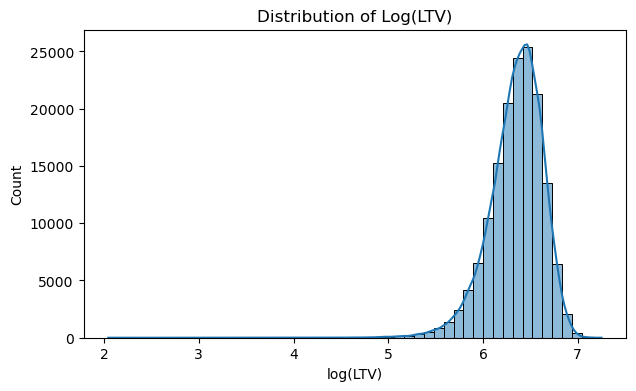

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.histplot(work["log_LTV"], bins=50, kde=True)
plt.title("Distribution of Log(LTV)")
plt.xlabel("log(LTV)")
plt.ylabel("Count")
plt.show()


### 티어별 LTV 상자그래프 (분포 비교)


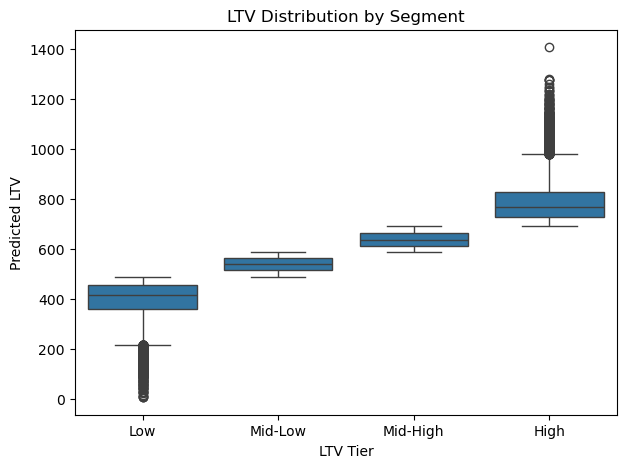

In [56]:
plt.figure(figsize=(7,5))
sns.boxplot(x="LTV_tier", y="pred_LTV", data=work,
            order=["Low","Mid-Low","Mid-High","High"])
plt.title("LTV Distribution by Segment")
plt.ylabel("Predicted LTV")
plt.xlabel("LTV Tier")
plt.show()

### 티어별 평균 LTV 막대그래프

/var/folders/ft/qy0hfkvd0rx250sfnxdbjr7r0000gn/T/ipykernel_7377/1826653429.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="LTV_tier", y="LTV_mean", data=seg_summary,


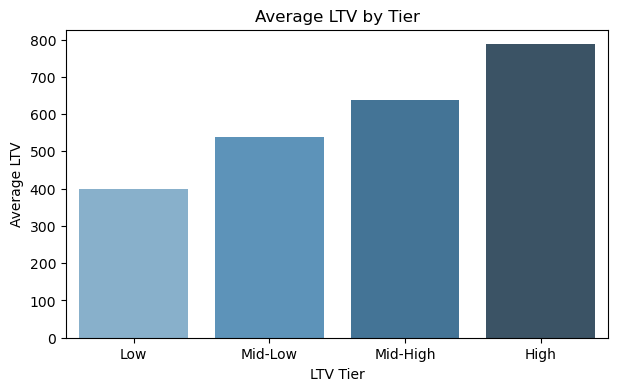

In [57]:
plt.figure(figsize=(7,4))
sns.barplot(x="LTV_tier", y="LTV_mean", data=seg_summary,
            order=["Low","Mid-Low","Mid-High","High"], palette="Blues_d")
plt.title("Average LTV by Tier")
plt.ylabel("Average LTV")
plt.xlabel("LTV Tier")
plt.show()


In [70]:
# 고객군별 요약 통계 계산
ltv_summary = (
    work.groupby("LTV_tier")["pred_LTV"]
        .agg(['count', 'mean', 'median', 'std'])
        .reset_index()
        .rename(columns={
            'count': '고객수',
            'mean': '평균 LTV',
            'median': '중위 LTV',
            'std': '표준편차'
        })
)

# 소수점 정리 (보기 좋게 반올림)
ltv_summary[['평균 LTV', '중위 LTV', '표준편차']] = ltv_summary[['평균 LTV', '중위 LTV', '표준편차']].round(2)

print("[고객 가치군별 요약표]")
display(ltv_summary)


[고객 가치군별 요약표]


/var/folders/ft/qy0hfkvd0rx250sfnxdbjr7r0000gn/T/ipykernel_7377/958037231.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby("LTV_tier")["pred_LTV"]
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,LTV_tier,고객수,평균 LTV,중위 LTV,표준편차
0,Low,39084,399.18,416.65,71.56
1,Mid-Low,39083,539.43,540.38,29.16
2,Mid-High,39083,638.85,637.93,29.66
3,High,39084,787.07,766.39,78.92


### 고객 세분화 검증

In [67]:
from scipy.stats import f_oneway, kruskal

# ANOVA (정규성 가정)
groups = [grp["pred_LTV"].values for _, grp in work.groupby("LTV_tier")]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA: F={f_stat:.3f}, p={p_val:.4e}")

# 비모수 대안 (Kruskal–Wallis)
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis: H={h_stat:.3f}, p={p_val:.4e}")


ANOVA: F=319449.209, p=0.0000e+00
Kruskal-Wallis: H=146562.188, p=0.0000e+00


/var/folders/ft/qy0hfkvd0rx250sfnxdbjr7r0000gn/T/ipykernel_7377/1402192895.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [grp["pred_LTV"].values for _, grp in work.groupby("LTV_tier")]


In [68]:
import pandas as pd
from scipy.stats import chi2_contingency

cross = pd.crosstab(ltv_merged["LTV_tier"], ltv_merged["policy_proxy_v2"])
chi2, p, dof, expected = chi2_contingency(cross)
print(f"카이제곱 검정: χ²={chi2:.3f}, p={p:.4f}")


카이제곱 검정: χ²=61.797, p=0.0000


### 고객데이터의 보험상품, 고객투자성향 변수와 merge해서 결과 확인

In [58]:
# work (LTV 결과) + df (고객 정보) 병합
ltv_merged = work.merge(
    df[["individual_id", "policy_proxy_v2", "strategy_type_final"]],
    on="individual_id", how="left"
)

print(ltv_merged.head())


   individual_id  churn_prob_1yr  churn_prob_2yr  churn_prob_3yr  \
0   2.213000e+11        0.000057        0.000057        0.000057   
1   2.213001e+11        0.000052        0.000052        0.000052   
2   2.213029e+11        0.000033        0.000033        0.000033   
3   2.213008e+11        0.000038        0.000038        0.000038   
4   2.213002e+11        0.000051        0.000051        0.000051   

   churn_prob_4yr  churn_prob_5yr  churn_prob_6yr  churn_prob_7yr  \
0        0.000057        0.000057        0.004376        0.069447   
1        0.000052        0.000052        0.004046        0.064369   
2        0.000033        0.000033        0.002519        0.040549   
3        0.000038        0.000038        0.002912        0.046735   
4        0.000051        0.000051        0.003912        0.062301   

   churn_prob_8yr  churn_prob_9yr  ...  survive_start_7yr  inc_churn_7yr  \
0        0.153993        0.280137  ...           0.995624       0.065071   
1        0.143229       

### 상품 유형별 LTV 비교

In [59]:
# policy_proxy_v2별 LTV 요약
summary_policy = (
    ltv_merged.groupby("policy_proxy_v2")
    .agg(
        n=("individual_id", "count"),
        LTV_mean=("pred_LTV", "mean"),
        LTV_std=("pred_LTV", "std"),
        LTV_median=("pred_LTV", "median")
    )
    .sort_values("LTV_mean", ascending=False)
)
print("\n▶ policy_proxy_v2별 LTV 요약")
print(summary_policy)


▶ policy_proxy_v2별 LTV 요약
                             n    LTV_mean     LTV_std  LTV_median
policy_proxy_v2                                                   
Variable Annuity         48104  593.511973  153.535372  591.150446
Variable Universal Life  50931  593.351956  153.565191  590.983976
Variable Whole Life      57299  587.161658  151.129909  584.732425


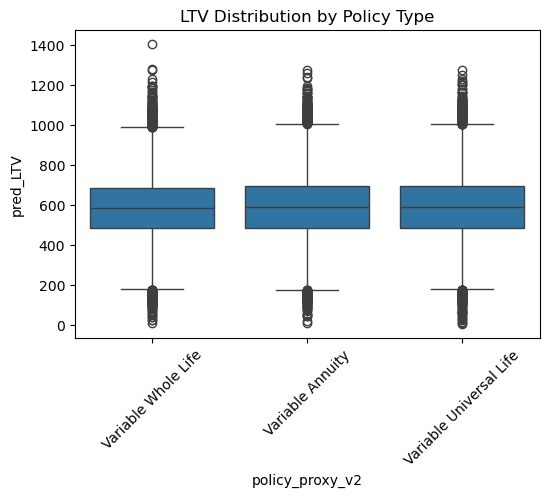

In [60]:
plt.figure(figsize=(6,4))
sns.boxplot(x="policy_proxy_v2", y="pred_LTV", data=ltv_merged)
plt.title("LTV Distribution by Policy Type")
plt.xticks(rotation=45)
plt.show()

### 전략 유형별 LTV 비교

In [61]:
# strategy_type_final별 LTV 요약
summary_strategy = (
    ltv_merged.groupby("strategy_type_final")
    .agg(
        n=("individual_id", "count"),
        LTV_mean=("pred_LTV", "mean"),
        LTV_std=("pred_LTV", "std"),
        LTV_median=("pred_LTV", "median")
    )
    .sort_values("LTV_mean", ascending=False)
)
print("\n▶ strategy_type_final별 LTV 요약")
print(summary_strategy)


▶ strategy_type_final별 LTV 요약
                          n    LTV_mean     LTV_std  LTV_median
strategy_type_final                                            
안정형                   26519  592.539994  150.763480  589.353774
혼합형                  104802  590.917168  153.081497  588.379262
공격형                   25013  590.541522  153.116557  588.828765


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) mi

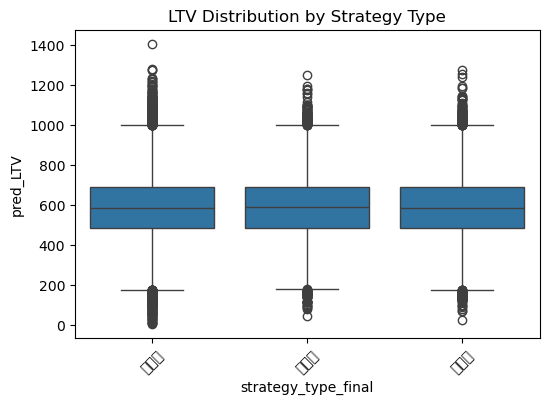

In [62]:
plt.figure(figsize=(6,4))
sns.boxplot(x="strategy_type_final", y="pred_LTV", data=ltv_merged)
plt.title("LTV Distribution by Strategy Type")
plt.xticks(rotation=45)
plt.show()

In [63]:
from scipy.stats import f_oneway

# policy_proxy_v2가 3개 이상 그룹일 때 (ANOVA)
groups_policy = [grp["pred_LTV"].values for _, grp in ltv_merged.groupby("policy_proxy_v2")]
f_stat, p_val = f_oneway(*groups_policy)
print(f"[policy_proxy_v2] F={f_stat:.3f}, p={p_val:.4f}")

# strategy_type_final도 3개 이상이면 같은 방식으로
groups_strategy = [grp["pred_LTV"].values for _, grp in ltv_merged.groupby("strategy_type_final")]
f_stat, p_val = f_oneway(*groups_strategy)
print(f"[strategy_type_final] F={f_stat:.3f}, p={p_val:.4f}")


[policy_proxy_v2] F=30.606, p=0.0000
[strategy_type_final] F=1.418, p=0.2422


상품 유형에 따라 LTV 평균이 통계적으로 다름

policy_proxy_v2 (상품 유형)   
Variable Whole Life, Variable Annuity, Variable Universal Life   
→ 보험상품 구조가 서로 다르기 때문에,   
납입기간·수익률·보장구조가 다르게 반영되어 LTV 차이가 납니다.    
즉, 상품 구조 자체가 고객의 장기 유지 및 수익 크기를 바꾼다는 의미.   
 
📌 strategy_type_final (투자 전략)    
공격형/혼합형/안정형은 투자 포트폴리오 비중일 뿐,    
실제 고객의 보험료 규모나 유지기간에는 큰 영향을 주지 않았을 가능성이 높습니다.   
즉, 투자성향이 LTV(=고객의 총 가치)에 큰 차이를 만들지는 못했다.    

# LTV_tier × 보험상품유형 교차비율표

In [72]:
cross_tab = (
    ltv_merged.pivot_table(
        index="LTV_tier", 
        columns="policy_proxy_v2", 
        values="individual_id", 
        aggfunc="count",
        fill_value=0
    )
)

# 각 LTV_tier 내에서 비율 계산 (%)
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

print("✅ [LTV 가치군별 보험상품유형 비율(%)]")
display(cross_tab_pct.round(2))

✅ [LTV 가치군별 보험상품유형 비율(%)]


/var/folders/ft/qy0hfkvd0rx250sfnxdbjr7r0000gn/T/ipykernel_7377/2245333712.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ltv_merged.pivot_table(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: CategoricalIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


policy_proxy_v2,Variable Annuity,Variable Universal Life,Variable Whole Life
LTV_tier,,,
Low,30.40,32.07,37.53
Mid-Low,30.38,32.31,37.31
Mid-High,30.69,32.64,36.67
High,31.61,33.30,35.09


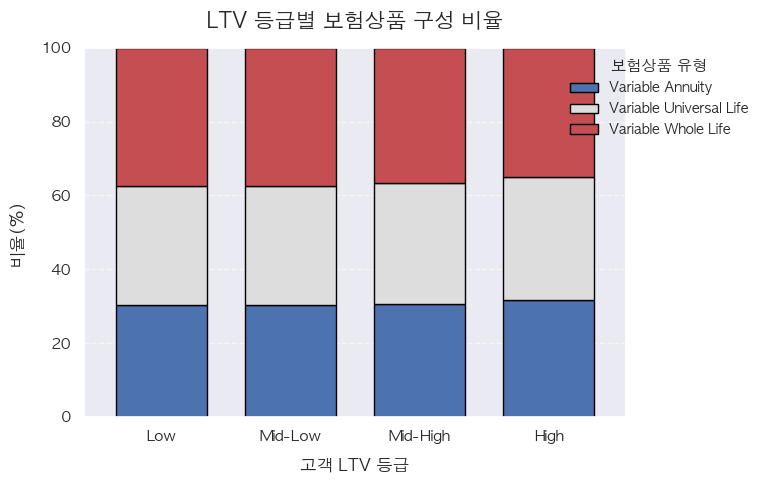

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 설정
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(font="AppleGothic", rc={"axes.unicode_minus": False})  # 한글 폰트 설정

# 그래프 그리기 (stacked bar)
cross_tab_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(8,5),
    color=["#4C72B0", "#DDDDDD", "#C44E52"],  # 파랑-회색-빨강 계열
    edgecolor="black",
    width=0.7
)

# 제목 및 축 설정
plt.title("LTV 등급별 보험상품 구성 비율", fontsize=15, fontweight='bold', pad=15)
plt.xlabel("고객 LTV 등급", fontsize=12, labelpad=10)
plt.ylabel("비율(%)", fontsize=12, labelpad=10)
plt.ylim(0, 100)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# 범례
plt.legend(
    title="보험상품 유형",
    title_fontsize=11,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(1.25, 1),
    frameon=False
)

# 격자 및 여백
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [79]:
import pandas as pd

# (1) LTV 결과(work) + 고객 데이터(df) 병합
ltv_merged = df.merge(
    work[["individual_id", "pred_LTV", "LTV_tier"]],
    on="individual_id",
    how="inner"
)

# (2) 요약 대상 변수 지정
cols_to_summarize = [
    "cpi_at_orig", "gdp_at_orig", "length_of_residence", "college_degree", 
    "has_children", "premium_to_income", "sp500_at_orig", "curr_ann_amt", 
    "dgs10_at_orig", "age_at_orig", "home_owner", "unrate_at_orig", "good_credit"
]

# (3) 그룹별 평균 (연속형 변수)
summary_mean = ltv_merged.groupby("LTV_tier")[cols_to_summarize].mean().round(2)

# (4) 이진 변수 비율(%) 계산
binary_cols = ["college_degree", "has_children", "home_owner", "good_credit"]
summary_rate = ltv_merged.groupby("LTV_tier")[binary_cols].mean().mul(100).round(1)

# (5) 결과 병합
summary_final = summary_mean.copy()
summary_final[binary_cols] = summary_rate[binary_cols]

# (6) 보기 좋게 정렬 (LTV 순서 고정)
ltv_order = ["Low", "Mid-Low", "Mid-High", "High"]
summary_final = summary_final.reindex(ltv_order)

summary_final



/var/folders/ft/qy0hfkvd0rx250sfnxdbjr7r0000gn/T/ipykernel_7377/863415888.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_mean = ltv_merged.groupby("LTV_tier")[cols_to_summarize].mean().round(2)
/var/folders/ft/qy0hfkvd0rx250sfnxdbjr7r0000gn/T/ipykernel_7377/863415888.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_rate = ltv_merged.groupby("LTV_tier")[binary_cols].mean().mul(100).round(1)
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(

,cpi_at_orig,gdp_at_orig,length_of_residence,college_degree,has_children,premium_to_income,sp500_at_orig,curr_ann_amt,dgs10_at_orig,age_at_orig,home_owner,unrate_at_orig,good_credit
LTV_tier,,,,,,,,,,,,,
Low,248.11,20141.45,6.26,30.1,55.6,0.01,2599.52,621.66,2.62,46.20,76.1,4.11,82.1
Mid-Low,248.14,20148.74,6.70,32.1,55.3,0.02,2602.07,840.10,2.62,46.64,78.7,4.11,83.6
Mid-High,248.22,20161.23,7.30,34.7,54.5,0.02,2605.23,994.97,2.62,47.11,81.9,4.11,85.1
High,248.31,20177.38,8.53,40.6,53.1,0.02,2609.24,1225.89,2.63,48.24,87.4,4.10,87.1
